# Sentiment Analysis: Machine Learning Approach

### Labeling

In [39]:
def review_labeling(data):
    df = pd.read_csv(data, header=None)
    
    # Apply the condition only to the second column (index 1)
    df[1] = df[1].apply(lambda x: 'positive' if x >= 4 else 'neutral' if 3 <= x < 4 else 'negative')
    
    return df

df_processed = review_labeling('Data/spotify_reviews_full.csv')
df_processed.columns = ["Tokens", "Label"]
print(df_processed)
df_processed.to_csv('Data/reviews_label_origin.csv', index=False)

                                                  Tokens     Label
0      Great music service, the audio is high quality...  positive
1      Please ignore previous negative rating. This a...  positive
2      This pop-up "Get the best Spotify experience o...  positive
3        Really buggy and terrible to use as of recently  negative
4      Dear Spotify why do I get songs that I didn't ...  negative
...                                                  ...       ...
61589  Even though it was communicated that lyrics fe...  negative
61590  Use to be sooo good back when I had it, and wh...  negative
61591  This app would be good if not for it taking ov...  negative
61592  The app is good hard to navigate and won't jus...  negative
61593  Its good but sometimes it doesnt load the musi...  positive

[61594 rows x 2 columns]


### Preprocessing

In [40]:
import numpy as np
import pandas as pd
import spacy
import emoji
import re
import nltk
from tqdm import tqdm
from nltk.sentiment.util import mark_negation


In [41]:
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to map emojis to text. E.g., "Python is 👍" is transformed to "Python is :thumbs_up:"
def map_emojis(text):
    """Convert emojis to their text representations."""
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Replace underscores with spaces in emoji descriptions to avoid them being omitted during tokenization.
    return text.replace('_', ' ')

# Preprocessing function
def preprocess_text(text):
    """Preprocess a single text string."""
    # Lowercase
    text = text.lower()

    # Convert emojis to text
    text = map_emojis(text)

    # Remove URLs and emails
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Tokenization and Lemmatization using spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_stop
    ]
    
    # Apply negation marking
    tokens = mark_negation(tokens)

    return ' '.join(tokens)

tqdm.pandas(desc="Preprocessing Reviews")
df_processed["Tokens"] = df_processed["Tokens"].progress_apply(preprocess_text)

print(df_processed)

df_processed.to_csv('Data/reviews_preprocessed.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Preprocessing Reviews: 100%|██████████| 61594/61594 [06:40<00:00, 153.90it/s]


                                                  Tokens     Label
0      great music service audio high quality app eas...  positive
1      ignore previous negative rating app super grea...  positive
2      pop good spotify experience android 12 annoyin...  positive
3                            buggy terrible use recently  negative
4                dear spotify song playlist shuffle play  negative
...                                                  ...       ...
61589  communicate lyric feature available user globa...  negative
61590  use sooo good download free version pick song ...  negative
61591  app good take device start comp spotify start ...  negative
61592  app good hard navigate will let play song clic...  negative
61593  good not load_NEG music_NEG play_NEG like_NEG ...  positive

[61594 rows x 2 columns]


### Train/Test Splitting

In [42]:
from sklearn import model_selection as ms

df_text = df_processed["Tokens"]
df_target = df_processed["Label"]

train_data, test_data, train_target, test_target = ms.train_test_split(df_text, df_target, test_size=0.2, random_state=993, stratify=df_target)

print(test_target)


30431    positive
53118    positive
30960    positive
34324    positive
59022    positive
           ...   
22075    positive
23612    positive
20156    negative
51588    negative
4962     negative
Name: Label, Length: 12319, dtype: object


### Count Vectorizer

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_features = cv.fit_transform(train_data)

print(train_features.shape)

#print(train_features[:3])

(49275, 20489)


In [44]:
from sklearn.preprocessing import Binarizer

transformer = Binarizer()
train_bin = transformer.fit_transform(train_features)
print(train_bin.shape)
print(train_bin[0])

(49275, 20489)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 16 stored elements and shape (1, 20489)>
  Coords	Values
  (0, 4427)	1
  (0, 14768)	1
  (0, 13765)	1
  (0, 6805)	1
  (0, 19452)	1
  (0, 984)	1
  (0, 16404)	1
  (0, 13350)	1
  (0, 10906)	1
  (0, 1693)	1
  (0, 2239)	1
  (0, 19477)	1
  (0, 8796)	1
  (0, 5156)	1
  (0, 7634)	1
  (0, 6981)	1


## Classification Process

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

text_clf = Pipeline([('vect', CountVectorizer(min_df=10, max_df=0.5)), 
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB()) # Classificiation
                    ])

text_clf.fit(train_data, train_target) 
predicted = text_clf.predict(test_data)


results = pd.DataFrame({
    'Actual': test_target,
    'Predicted': predicted
})

### Confustion Matrix

Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.81      0.77      4954
     neutral       0.28      0.15      0.20      1377
    positive       0.83      0.84      0.83      5988

    accuracy                           0.75     12319
   macro avg       0.61      0.60      0.60     12319
weighted avg       0.73      0.75      0.74     12319



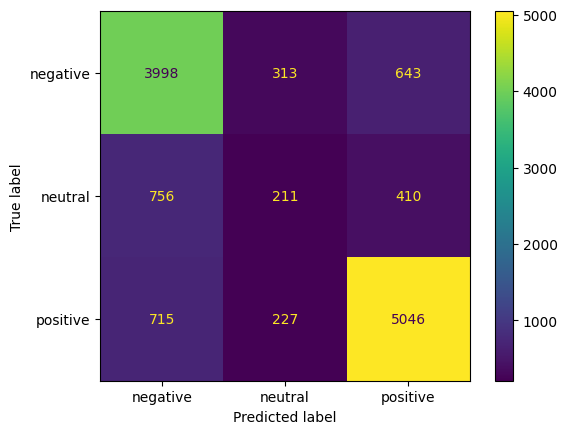

In [46]:
conf_matrix = confusion_matrix(test_target, predicted)
print("Confusion Matrix:")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=text_clf.classes_)
disp.plot()

# Classification Report
report = classification_report(test_target, predicted, target_names=text_clf.classes_)
print("Classification Report:")
print(report)